# [Baseball Databank](http://www.seanlahman.com/baseball-archive/statistics/)

In [1252]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1253]:
from pathlib import Path
from typing import Tuple, Callable

In [1254]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [1255]:
# show matplotlib plots in notebook
%matplotlib inline

In [1256]:
# set matplotlib style/theme
plt.style.use("fivethirtyeight")

In [1257]:
# plotly defaults
pio.renderers.default = "notebook"
pio.templates.default = "seaborn"

In [1258]:
from tabulate import tabulate
from IPython.core.display import display, Markdown, HTML

def markdown(s: str):
    display(Markdown(s))
    
def html(s: str):
    display(HTML(s))

In [1259]:
# path to data files
datapath = Path("../baseballdatabank/core")

___________________
## Batting info

In [1260]:
batting = pd.read_csv(datapath/"batting.csv")
batting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108789 entries, 0 to 108788
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   playerID  108789 non-null  object 
 1   yearID    108789 non-null  int64  
 2   stint     108789 non-null  int64  
 3   teamID    108789 non-null  object 
 4   lgID      108052 non-null  object 
 5   G         108789 non-null  int64  
 6   AB        108789 non-null  int64  
 7   R         108789 non-null  int64  
 8   H         108789 non-null  int64  
 9   2B        108789 non-null  int64  
 10  3B        108789 non-null  int64  
 11  HR        108789 non-null  int64  
 12  RBI       108033 non-null  float64
 13  SB        106421 non-null  float64
 14  CS        85248 non-null   float64
 15  BB        108789 non-null  int64  
 16  SO        106689 non-null  float64
 17  IBB       72139 non-null   float64
 18  HBP       105973 non-null  float64
 19  SH        102721 non-null  float64
 20  SF  

## People info

In [1261]:
people = pd.read_csv(datapath/"people.csv")
for col in "debut", "finalGame":
    people[col] = pd.to_datetime(people[col])
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20093 entries, 0 to 20092
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   playerID      20093 non-null  object        
 1   birthYear     19979 non-null  float64       
 2   birthMonth    19811 non-null  float64       
 3   birthDay      19670 non-null  float64       
 4   birthCountry  20032 non-null  object        
 5   birthState    19561 non-null  object        
 6   birthCity     19919 non-null  object        
 7   deathYear     9887 non-null   float64       
 8   deathMonth    9886 non-null   float64       
 9   deathDay      9885 non-null   float64       
 10  deathCountry  9884 non-null   object        
 11  deathState    9836 non-null   object        
 12  deathCity     9878 non-null   object        
 13  nameFirst     20056 non-null  object        
 14  nameLast      20093 non-null  object        
 15  nameGiven     20056 non-null  object

In [1262]:
# slimmed people dataframe with player ID, full name, first and final games as datetimes
people_slim = pd.concat([people["playerID"], 
                         people[["nameFirst", "nameLast"]].fillna("").agg(" ".join, axis=1).rename("fullName"), 
                         people["debut"].apply(lambda dt: dt.year).fillna(0).astype(np.int), 
                         people["finalGame"].apply(lambda dt: dt.year).fillna(0).astype(np.int)], 
                        axis=1)

In [1263]:
people_slim

,playerID,fullName,debut,finalGame
0,aardsda01,David Aardsma,2004,2015
1,aaronha01,Hank Aaron,1954,1976
2,aaronto01,Tommie Aaron,1962,1971
3,aasedo01,Don Aase,1977,1990
4,abadan01,Andy Abad,2001,2006
...,...,...,...,...
20088,zupofr01,Frank Zupo,1957,1961
20089,zuvelpa01,Paul Zuvella,1982,1991
20090,zuverge01,George Zuverink,1951,1959
20091,zwilldu01,Dutch Zwilling,1910,1916


_____________________
### Convenience functions

In [1306]:
# All-time <stat> leaders (using sum aggregation)
def leaders(df_stat: pd.DataFrame, df_people: pd.DataFrame, stat: str, count: int=10):
    _leaders = (df_stat.pivot_table(values=stat, columns="yearID", index="playerID", fill_value=0, aggfunc=np.sum)
                  .astype(np.int)
                  .sum(axis=1)
                  .sort_values(ascending=False)
                  .rename(stat)
                  .head(count))
    return pd.merge(df_people, _leaders, on="playerID").sort_values(stat, ascending=False)

In [1314]:
# All-time <stat> leaders (using mean aggregation)
def leaders_mean(df_stat: pd.DataFrame, df_people: pd.DataFrame, stat: str, count: int=10):
    _leaders = (df_stat.pivot_table(values=stat, columns="yearID", index="playerID", aggfunc=np.mean)
                  .mean(axis=1)
                  .sort_values(ascending=False)
                  .rename(stat)
                  .head(count))
    return pd.merge(df_people, _leaders, on="playerID").sort_values(stat, ascending=False)

In [1347]:
# Bar-plot leaders
def leaders_barplot_sns(df: pd.DataFrame, stat: str, figsize: Tuple[int, int]=(7,6), stat_label: str=None):
    if stat_label is None:
        stat_label = stat
    plt.figure(figsize=figsize)
    bp = sns.barplot(x="fullName", y=stat, data=df, palette="crest_r")
    bp.set(xlabel=None, ylabel=f"Career {stat_label}", title=f"All-time {stat_label} Leaders")
    bp.set_xticklabels(bp.get_xticklabels(), rotation=60)
    plt.tight_layout()
    return bp

**NOTE** the bizarre name difference betwen setting ```custom_data``` and using ```customdata``` in plotly.express

In [1329]:
# plotly plot
def leaders_barplot_plotly(df: pd.DataFrame, stat:str, stat_label: str=None):
    if stat_label is None:
        stat_label = stat
    bp = px.bar(df, 
                x="fullName", 
                y=stat, 
                title=f"All-time {stat_label} Leaders",
                custom_data=["debut", "finalGame"])
    bp.update_traces(hovertemplate="<b>%{x}</b>: %{y} (%{customdata[0]}-%{customdata[1]})")
    bp.update_xaxes(title=None)
    bp.update_yaxes(title=f"Career {stat_label}")
    return bp

# Players: all-time batting leaders

## HR

In [1267]:
hr_leaders = leaders(batting, people_slim, "HR", 10)
hr_leaders

,playerID,fullName,debut,finalGame,HR
1,bondsba01,Barry Bonds,1986,2007,762
0,aaronha01,Hank Aaron,1954,1976,755
7,ruthba01,Babe Ruth,1914,1935,714
6,rodrial01,Alex Rodriguez,1994,2016,696
4,pujolal01,Albert Pujols,2001,2020,662
3,mayswi01,Willie Mays,1951,1973,660
2,griffke02,Ken Griffey,1989,2010,630
9,thomeji01,Jim Thome,1991,2012,612
8,sosasa01,Sammy Sosa,1989,2007,609
5,robinfr02,Frank Robinson,1956,1976,586


<AxesSubplot:title={'center':'All-time Home Run Leaders'}, ylabel='Career Home Run'>

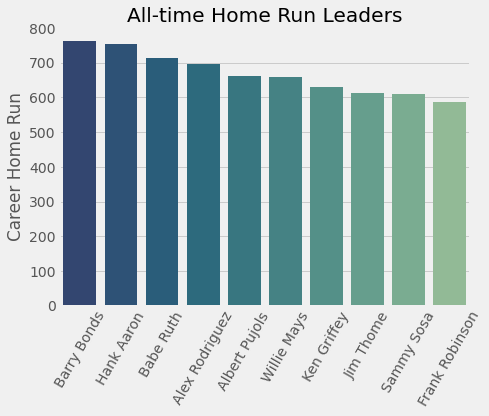

In [1348]:
# seaborn plot
leaders_barplot_sns(hr_leaders, "HR", stat_label="Home Run")

In [1332]:
leaders_barplot_plotly(hr_leaders, "HR", stat_label="Home Run")

## Hits

In [1270]:
h_leaders = leaders(batting, people_slim, "H", 10)
h_leaders

,playerID,fullName,debut,finalGame,H
6,rosepe01,Pete Rose,1963,1986,4256
2,cobbty01,Ty Cobb,1905,1928,4189
0,aaronha01,Hank Aaron,1954,1976,3771
5,musiast01,Stan Musial,1941,1963,3630
7,speaktr01,Tris Speaker,1907,1928,3514
3,jeterde01,Derek Jeter,1995,2014,3465
1,ansonca01,Cap Anson,1871,1897,3435
8,wagneho01,Honus Wagner,1897,1917,3420
9,yastrca01,Carl Yastrzemski,1961,1983,3419
4,molitpa01,Paul Molitor,1978,1998,3319


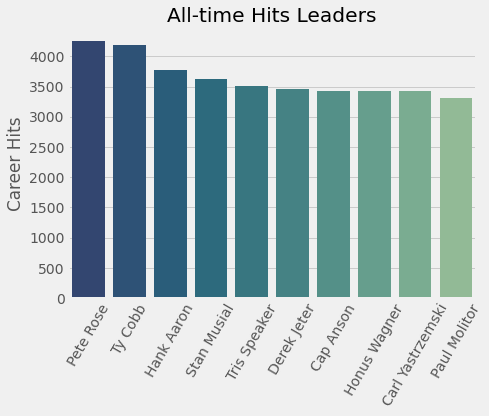

In [1333]:
leaders_barplot_sns(h_leaders, "H", stat_label="Hits")

In [1334]:
leaders_barplot_plotly(h_leaders, "H", stat_label="Hits")

## RBI

In [1273]:
rbi_leaders = leaders(batting, people_slim, "RBI")
rbi_leaders

,playerID,fullName,debut,finalGame,RBI
0,aaronha01,Hank Aaron,1954,1976,2297
9,ruthba01,Babe Ruth,1914,1935,2217
7,pujolal01,Albert Pujols,2001,2020,2100
8,rodrial01,Alex Rodriguez,1994,2016,2086
1,ansonca01,Cap Anson,1871,1897,2075
2,bondsba01,Barry Bonds,1986,2007,1996
5,gehrilo01,Lou Gehrig,1923,1939,1995
6,musiast01,Stan Musial,1941,1963,1951
3,cobbty01,Ty Cobb,1905,1928,1944
4,foxxji01,Jimmie Foxx,1925,1945,1922


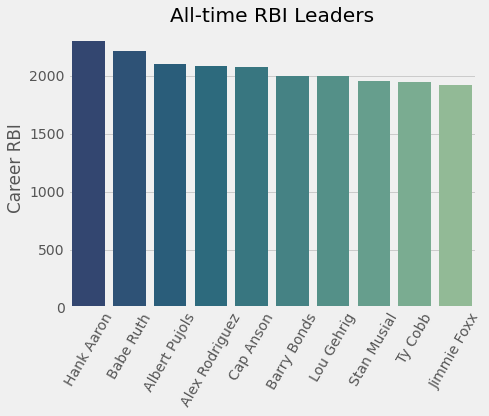

In [1274]:
leaders_barplot_sns(rbi_leaders, "RBI")

In [1335]:
leaders_barplot_plotly(rbi_leaders, "RBI")

## Runs Scored

In [1276]:
r_leaders = leaders(batting, people_slim, "R")
r_leaders

,playerID,fullName,debut,finalGame,R
4,henderi01,Rickey Henderson,1979,2003,2295
3,cobbty01,Ty Cobb,1905,1928,2247
2,bondsba01,Barry Bonds,1986,2007,2227
0,aaronha01,Hank Aaron,1954,1976,2174
9,ruthba01,Babe Ruth,1914,1935,2174
8,rosepe01,Pete Rose,1963,1986,2165
5,mayswi01,Willie Mays,1951,1973,2062
7,rodrial01,Alex Rodriguez,1994,2016,2021
1,ansonca01,Cap Anson,1871,1897,1999
6,musiast01,Stan Musial,1941,1963,1949


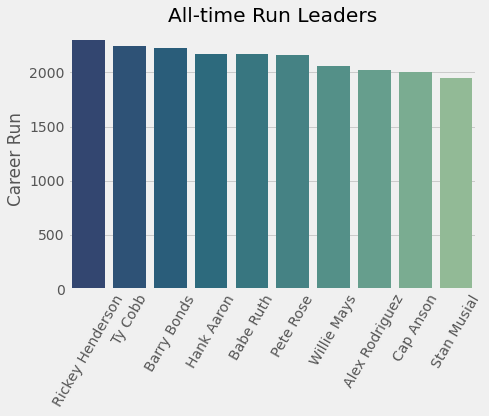

In [1336]:
leaders_barplot_sns(r_leaders, "R", stat_label="Run")

In [1337]:
leaders_barplot_plotly(r_leaders, "R", stat_label="Run")

## Games Played

In [1279]:
g_leaders = leaders(batting, people_slim, "G")
g_leaders

,playerID,fullName,debut,finalGame,G
8,rosepe01,Pete Rose,1963,1986,3562
9,yastrca01,Carl Yastrzemski,1961,1983,3308
0,aaronha01,Hank Aaron,1954,1976,3298
3,henderi01,Rickey Henderson,1979,2003,3081
2,cobbty01,Ty Cobb,1905,1928,3035
5,murraed02,Eddie Murray,1977,1997,3026
6,musiast01,Stan Musial,1941,1963,3026
7,ripkeca01,Cal Ripken,1981,2001,3001
4,mayswi01,Willie Mays,1951,1973,2992
1,bondsba01,Barry Bonds,1986,2007,2986


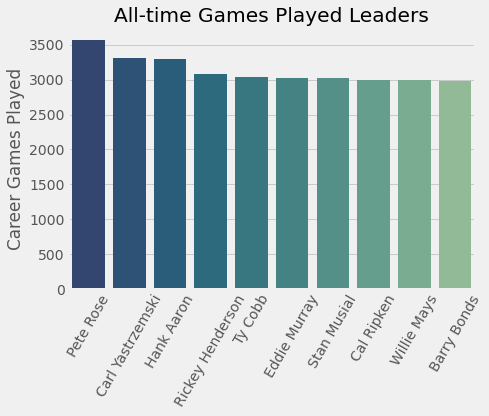

In [1338]:
leaders_barplot_sns(g_leaders, "G", stat_label="Games Played")

In [1339]:
leaders_barplot_plotly(g_leaders, "G", "Games Played")

## Stolen Bases

In [1282]:
sb_leaders = leaders(batting, people_slim, "SB")
sb_leaders

,playerID,fullName,debut,finalGame,SB
6,henderi01,Rickey Henderson,1979,2003,1406
0,brocklo01,Lou Brock,1961,1979,938
5,hamilbi01,Billy Hamilton,1888,1901,914
2,cobbty01,Ty Cobb,1905,1928,896
8,raineti01,Tim Raines,1979,2002,808
3,colemvi01,Vince Coleman,1985,1997,752
7,lathaar01,Arlie Latham,1880,1909,742
4,collied01,Eddie Collins,1906,1930,741
1,careyma01,Max Carey,1910,1929,738
9,wagneho01,Honus Wagner,1897,1917,723


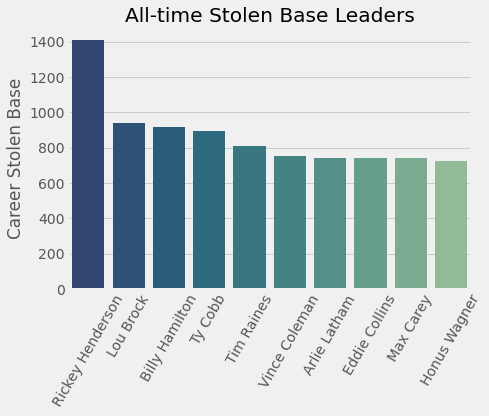

In [1341]:
leaders_barplot_sns(sb_leaders, "SB", stat_label="Stolen Base")

In [1284]:
leaders_barplot_plotly(sb_leaders, "SB", "Stolen Base")

## Net Stolen Bases (Stolen Bases - Caught Stealing)

In [1285]:
batting["NetSB"] = batting["SB"] - batting["CS"]

In [1286]:
nsb_leaders = leaders(batting, people_slim, "NetSB")
nsb_leaders

,playerID,fullName,debut,finalGame,NetSB
3,henderi01,Rickey Henderson,1979,2003,1071
8,raineti01,Tim Raines,1979,2002,662
0,brocklo01,Lou Brock,1961,1979,631
2,colemvi01,Vince Coleman,1985,1997,575
9,wilsowi02,Willie Wilson,1976,1994,534
6,morgajo02,Joe Morgan,1963,1984,527
4,loftoke01,Kenny Lofton,1991,2007,462
1,campabe01,Bert Campaneris,1964,1983,450
5,lopesda01,Davey Lopes,1972,1987,443
7,nixonot01,Otis Nixon,1983,1999,434


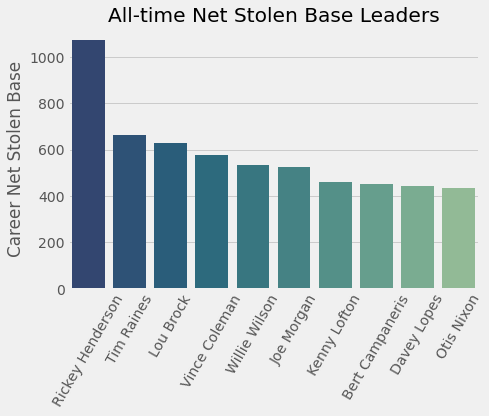

In [1342]:
leaders_barplot_sns(nsb_leaders, "NetSB", stat_label="Net Stolen Base")

In [1344]:
leaders_barplot_plotly(nsb_leaders, "NetSB", stat_label="Net Stolen Base")

## Batting average

In [1302]:
batting["AVG"] = batting["H"] / batting["AB"]

### Highest single-season batting average (with AB > 100)

In [1443]:
people_slim[people_slim["playerID"] == "meyerle01"]

,playerID,fullName,debut,finalGame
12178,meyerle01,Levi Meyerle,1871,1884


In [1461]:
highest_avg = batting[batting["AB"] > 100].sort_values("AVG", ascending=False).head(10)
highest_avg["fullName"] = highest_avg["playerID"].apply(
    lambda pid: people_slim[people_slim["playerID"] == pid]["fullName"].iloc[0])
highest_avg["yearID"] = highest_avg["yearID"].astype(str)
highest_avg["fullName"] = highest_avg[["fullName", "yearID"]].fillna("").agg(", ".join, axis=1)
highest_avg

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,BB,SO,IBB,HBP,SH,SF,GIDP,NetSB,AVG,fullName
75,meyerle01,1871,1,PH1,NaN,26,130,45,64,9,...,2,1.0,NaN,NaN,NaN,NaN,0.0,4.0,0.492308,"Levi Meyerle, 1871"
6141,duffyhu01,1894,1,BSN,NL,125,539,160,237,51,...,66,15.0,NaN,1.0,10.0,NaN,NaN,NaN,0.439703,"Hugh Duffy, 1894"
3680,oneilti01,1887,1,SL4,AA,124,517,167,225,52,...,50,20.0,NaN,5.0,NaN,NaN,NaN,NaN,0.435203,"Tip O'Neill, 1887"
74,mcveyca01,1871,1,BS1,NaN,29,153,43,66,9,...,1,2.0,NaN,NaN,NaN,NaN,0.0,6.0,0.431373,"Cal McVey, 1871"
281,barnero01,1873,1,BS1,NaN,60,320,125,138,31,...,20,2.0,NaN,NaN,NaN,NaN,1.0,37.0,0.431250,"Ross Barnes, 1873"
124,barnero01,1872,1,BS1,NaN,45,230,81,99,28,...,9,4.0,NaN,NaN,NaN,NaN,3.0,10.0,0.430435,"Ross Barnes, 1872"
742,barnero01,1876,1,CHN,NL,66,322,126,138,21,...,20,8.0,NaN,NaN,NaN,NaN,NaN,NaN,0.428571,"Ross Barnes, 1876"
8335,lajoina01,1901,1,PHA,AL,131,544,145,232,48,...,24,9.0,NaN,13.0,1.0,NaN,NaN,NaN,0.426471,"Nap Lajoie, 1901"
7108,keelewi01,1897,1,BLN,NL,129,564,145,239,27,...,35,5.0,NaN,7.0,12.0,NaN,NaN,NaN,0.423759,"Willie Keeler, 1897"
20466,hornsro01,1924,1,SLN,NL,143,536,121,227,43,...,89,32.0,NaN,2.0,13.0,NaN,NaN,-7.0,0.423507,"Rogers Hornsby, 1924"


[Text(10.57, 0.5, 'Single-season Batting Average'),
 Text(0.5, 1.0, 'Highest Single-season Batting Averages')]

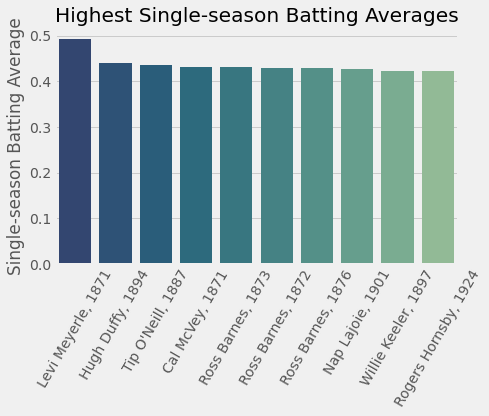

In [1462]:
bp = leaders_barplot_sns(highest_avg, "AVG", stat_label="Single-season Batting Average")
bp.set(ylabel="Single-season Batting Average", title="Highest Single-season Batting Averages")

In [1464]:
bp = px.bar(highest_avg, 
            x="fullName", 
            y="AVG", 
            title=f"Highest Single-season Batting Average",
            custom_data=["AB"])
bp.update_traces(hovertemplate="<b>%{x}</b>: %{y}, (%{customdata[0]} AB)")
bp.update_xaxes(title=None)
bp.update_yaxes(title=f"Batting Average")

### Highest average Batting Average across career (seaons with at least 100 AB)

In [1363]:
avg_leaders = leaders_mean(batting[batting["AB"] > 100], people_slim, "AVG", count=15)
avg_leaders

,playerID,fullName,debut,finalGame,AVG
6,hazlebo01,Bob Hazle,1955,1958,0.402985
3,daviscu01,Curt Davis,1934,1946,0.380952
4,fishesh01,Showboat Fisher,1923,1932,0.374016
14,woltery01,Rynie Wolters,1871,1873,0.369565
0,barnero01,Ross Barnes,1871,1881,0.366576
11,meyerle01,Levi Meyerle,1871,1884,0.363725
2,cobbty01,Ty Cobb,1905,1928,0.360939
7,hornsro01,Rogers Hornsby,1915,1937,0.356378
8,jacksjo01,Shoeless Joe Jackson,1908,1920,0.354336
5,harveza01,Zaza Harvey,1900,1902,0.352941


<ipython-input-1364-d6f8795e6a19>:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, 0.0, '0.000'),
 Text(0, 0.1, '0.100'),
 Text(0, 0.2, '0.200'),
 Text(0, 0.30000000000000004, '0.300'),
 Text(0, 0.4, '0.400'),
 Text(0, 0.5, '0.500')]

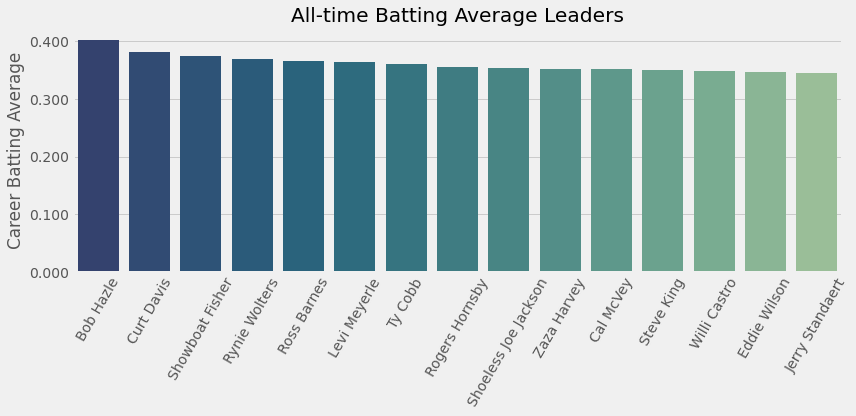

In [1364]:
bp = leaders_barplot_sns(avg_leaders, "AVG", stat_label="Batting Average", figsize=(12,6))
bp.set_yticklabels(['{:.3f}'.format(y) for y in bp.get_yticks()])

In [1365]:
bp = leaders_barplot_plotly(avg_leaders, "AVG", stat_label="Batting Average")
bp.update_yaxes(tickformat=".3f")

### Highest career-level batting average (career H/AB, with career AB > 100)

In [1389]:
hits = batting[batting["AB"] > 100].pivot_table(values="H", columns="yearID", index="playerID").sum(axis=1)
ab = batting[batting["AB"] > 100].pivot_table(values="AB", columns="yearID", index="playerID").sum(axis=1)
career_avg = (hits / ab).rename("Career AVG")
career_avg_leaders = pd.merge(people_slim, career_avg, on="playerID").sort_values("Career AVG", ascending=False).head(10)
career_avg_leaders

,playerID,fullName,debut,finalGame,Career AVG
2764,hazlebo01,Bob Hazle,1955,1958,0.402985
1535,daviscu01,Curt Davis,1934,1946,0.380952
2018,fishesh01,Showboat Fisher,1923,1932,0.374016
6902,woltery01,Rynie Wolters,1871,1873,0.369565
1204,cobbty01,Ty Cobb,1905,1928,0.366299
318,barnero01,Ross Barnes,1871,1881,0.363201
2977,hornsro01,Rogers Hornsby,1915,1937,0.361542
3111,jacksjo01,Shoeless Joe Jackson,1908,1920,0.359479
4292,meyerle01,Levi Meyerle,1871,1884,0.357542
4725,odoulle01,Lefty O'Doul,1919,1934,0.357238


<ipython-input-1465-54761c38c274>:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, 0.0, '0.000'),
 Text(0, 0.1, '0.100'),
 Text(0, 0.2, '0.200'),
 Text(0, 0.30000000000000004, '0.300'),
 Text(0, 0.4, '0.400'),
 Text(0, 0.5, '0.500')]

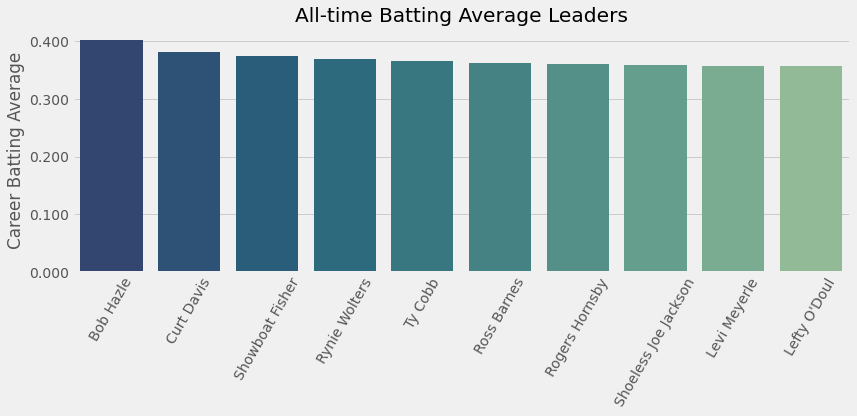

In [1465]:
bp = leaders_barplot_sns(career_avg_leaders, "Career AVG", stat_label="Batting Average", figsize=(12,6))
bp.set_yticklabels(['{:.3f}'.format(y) for y in bp.get_yticks()])

In [1467]:
bp = leaders_barplot_plotly(career_avg_leaders, "Career AVG", stat_label="Batting Average")
bp.update_yaxes(tickformat=".3f")

______________________________________________